In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.colors as meepo

In [3]:
clf = joblib.load('models/train_SLSN.joblib')
features = pd.read_parquet('test_sample/test_SLSN_features.parquet').dropna()
data = pd.read_parquet('test_sample/test_sample.parquet')
features['target'] = data['target']
X, y = features.iloc[:, 1:-1], np.where((features['target']==2246)|(features['target']==2242), 1, 0)

X.head()

,ra,dec,hostgal_dist,hostgal_zphot,hostgal_zphot_err,peak,std_0,std_1,std_2,std_3,...,p1_blue,p2_blue,p3_blue,chi2_blue,p1_red,p2_red,p3_red,chi2_red,std_color,max_color
0,141.855469,-3.284369,-9.000000,-9.000000,-9.00000,65264.925781,-1.000000,0.000000,0.346103,0.386698,...,-4.264198e-02,0.104772,79.196267,9.202289e+01,-6.682950e-02,0.110573,33.322370,121.064347,29047.825203,61712.748492
1,172.089844,-39.450895,-9.000000,-9.000000,-9.00000,-11087.990234,-1.000000,-1.000000,0.111894,0.603707,...,-5.431101e-01,2.000000,0.765333,-7.125769e-03,-6.262305e-01,2.000000,4.445296,-10.454247,32143.565055,65720.469726
2,59.400000,-76.261503,569.341275,0.199976,0.20422,-4580.801270,0.000000,0.000000,0.057555,0.140098,...,-1.958837e-02,0.062268,27.547472,-5.161726e-30,-5.591140e-14,0.003027,-300.000000,-0.626083,4958.193675,-9773.509766
4,119.531250,-11.567418,-9.000000,-9.000000,-9.00000,7744.518066,0.042321,0.289262,0.971567,0.773542,...,-1.526886e-22,0.029271,15.880884,1.471389e+02,-6.343985e-16,0.016571,17.789452,93.365447,6487.762258,-13554.029149
5,145.722656,-37.544325,254.983050,0.737487,0.69066,11666.380859,-1.000000,-1.000000,0.144163,0.166142,...,-1.529611e-02,0.042472,47.747100,5.778229e-02,-1.752177e-02,0.053124,42.934955,0.022194,476.952070,-1389.747410


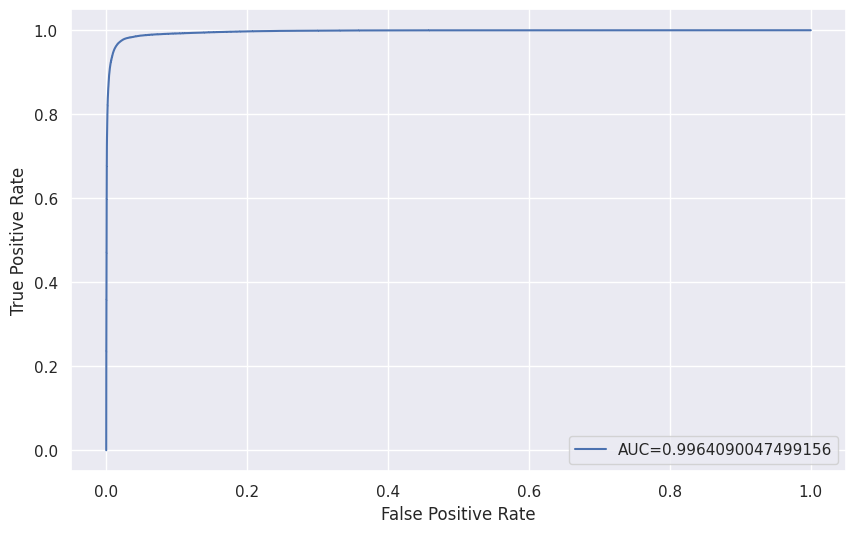

The most top left point on the ROC curve correspond to threshold  0.3227328715814052


In [4]:
#define metrics
proba = clf.predict_proba(X)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y,  proba)
auc = metrics.roc_auc_score(y, proba)

#create ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

optimal_threshold = _[np.argmin((fpr)**2 + (1-tpr)**2)]
print("The most top left point on the ROC curve correspond to threshold ", optimal_threshold)

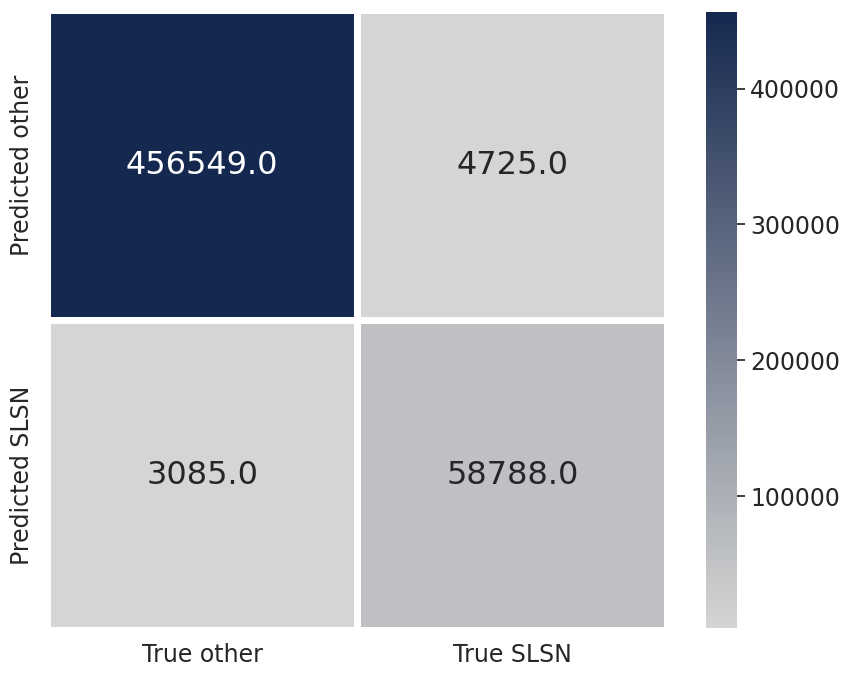

In [10]:
normalize = False

thresh = 0.5
proba = clf.predict_proba(X)[:, 1]
pred = np.where(proba>thresh, 1, 0)

if normalize:
    conf = confusion_matrix(pred, y, normalize='all')
    conf = conf*100
else:
    conf = confusion_matrix(pred, y)

myColors = ('#D5D5D3', '#15284F')
mymap = meepo.LinearSegmentedColormap.from_list('Custom', myColors, 500)

sns.set(rc = {'figure.figsize':(10,10)})
fig, ax0 = plt.subplots(1,1)

ax = sns.heatmap(conf, annot=True, fmt = '.1f', square=1, linewidth=5, annot_kws={"size":23},\
                 cmap=mymap, cbar_kws={"shrink": 0.8})

ax.set_xticklabels(labels=['True other', 'True SLSN'], fontsize=17)
ax.set_yticklabels(labels=['Predicted other', 'Predicted SLSN'], fontsize=17)

if normalize:
    for t in ax.texts: t.set_text(t.get_text() + " %")

# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)

print()

In [6]:
importance = clf.feature_importances_
cols = X.columns
importance, cols = zip(*sorted(zip(importance, cols), reverse=True))

print('Ten most important features :\n')
for idx, col in enumerate(cols[:10]):
        print(f"{col} : {importance[idx]:.3f}")

Ten most important features :

mean_snr_5 : 0.061
hostgal_zphot : 0.058
std_2 : 0.058
peak : 0.057
hostgal_zphot_err : 0.055
mean_snr_4 : 0.047
max_color : 0.042
p3_red : 0.041
mean_snr_3 : 0.039
std_color : 0.039


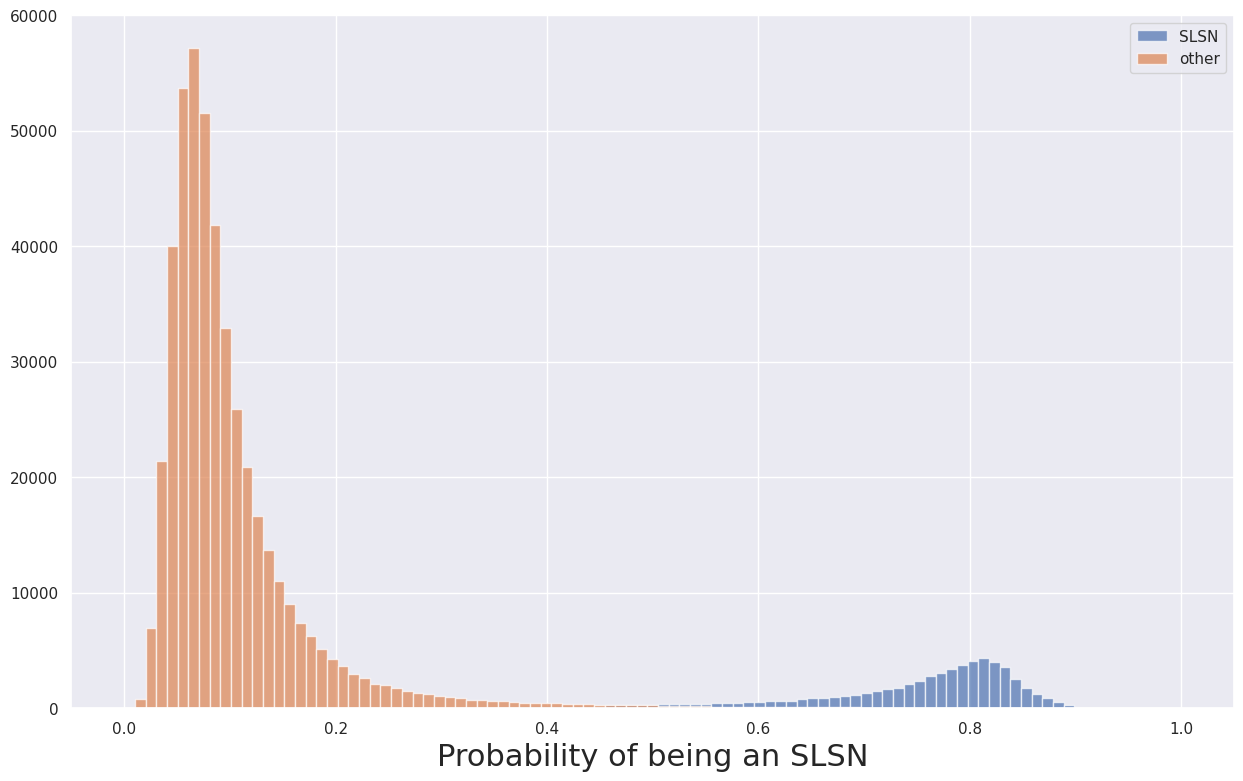

In [8]:
bins = np.linspace(0, 1, 100)

plt.figure(figsize=(15, 9))
plt.hist(proba[y==1], bins=bins, alpha=0.7, label='SLSN')
plt.hist(proba[y==0], bins=bins, alpha=0.7, label='other')
plt.xlabel('Probability of being an SLSN', fontsize=22)
#plt.yscale("log")
plt.legend()